In [1]:
import json
import pydub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.io.wavfile as wv

In [2]:
file_src = "./feel_the_rythm_of_korea.mp3"

seg = pydub.AudioSegment.from_mp3(file_src)
wav = np.float32(np.array(seg.get_array_of_samples())) / 2**15

In [3]:
seg

In [4]:
pd.DataFrame(wav).describe()

,0
count,9.250340e+06
mean,1.171815e-04
std,2.994603e-01
min,-1.000000e+00
25%,-1.855164e-01
50%,-2.410889e-03
75%,1.864929e-01
max,9.999695e-01


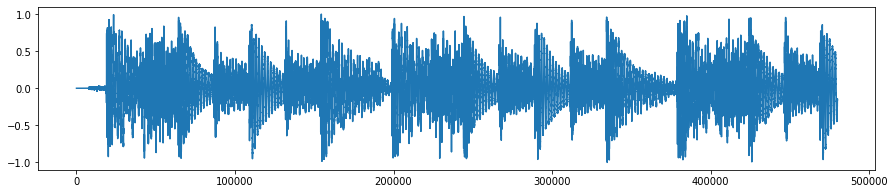

In [5]:
rate = seg.frame_rate
start_second = 0
end_second = 10

plt.figure(figsize=(15, 3))
plt.plot(wav[start_second * rate:end_second * rate])
plt.show()

In [6]:
class STFTConverter:
    def __init__(self):
        pass
    
    @staticmethod
    def get_stft_from_wave(wave,comp):
        D = librosa.core.stft(wave, n_fft=4096)  # 1+2046/2 =1,024
        if comp == False:
            mag, phase = librosa.magphase(D)
            db, angle = librosa.amplitude_to_db(mag), np.angle(phase)
            db, angle = np.transpose(db, (1, 0)), np.transpose(angle, (1, 0))
        elif comp == True:
            db, angle = np.transpose(D.real,(1,0)), np.transpose(D.imag,(1,0))
        return db, angle
    
    def get_stft(self, wave, comp=False):
        """
        Returns [log_magnitude, radian_phase], cropped_wave
        """
        db, angle = self.get_stft_from_wave(wave,comp)
        converted = np.stack([db, angle], axis=0)
        return converted

    def stft2wav(self, stft):
        db, angle = np.transpose(stft[0], (1, 0)), np.transpose(stft[1], (1, 0))
        mag = librosa.core.db_to_amplitude(db)
        phase = np.cos(angle) + 1j * np.sin(angle)
        D = mag * phase
        y_hat = librosa.core.istft(D)
        return y_hat

stft = STFTConverter()

In [7]:
spectrogram = stft.get_stft(wav)

In [8]:
mag = spectrogram[0,:,:]
phase = spectrogram[1,:,:]

mag = mag[:, :mag.shape[1]//8]
max_mag = np.max(mag)
min_mag = np.min(mag)
mag -= min_mag
mag /= max_mag-min_mag
mag *= 100
mag = mag.astype(np.ubyte)

In [9]:
# downsample
mag_ = np.array([])
sample_ratio = 1
for i in range(mag.shape[0]//sample_ratio):
    mag_ = np.append(mag_, mag[i * sample_ratio])

mag_ = mag_.reshape((mag_.shape[0]//mag.shape[1], mag.shape[1]))
mag = mag_

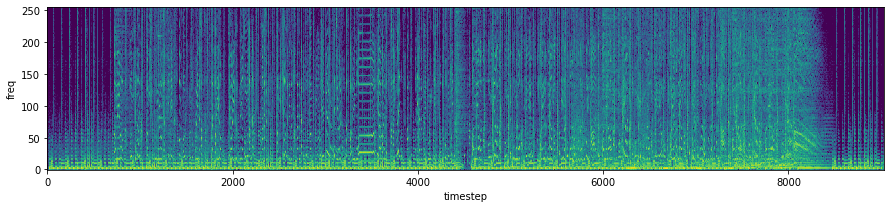

In [10]:
plt.figure(figsize=(15, 3))
plt.imshow(np.transpose(mag), aspect='auto')
plt.xlabel('timestep')
plt.ylabel('freq')
plt.gca().invert_yaxis()
plt.show()

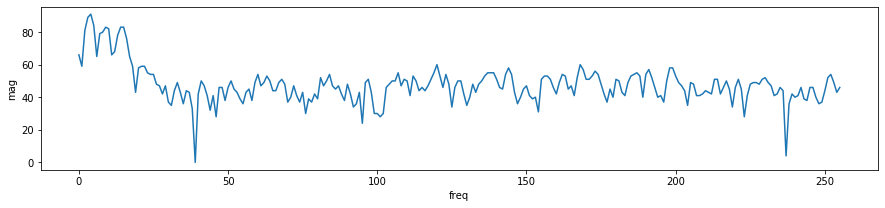

In [11]:
plt.figure(figsize=(15, 3))
plt.xlabel('freq')
plt.ylabel('mag')
plt.plot(mag[503])
plt.show()

In [12]:
total_sec = len(wav) / seg.frame_rate
total_sec

192.71541666666667

In [13]:
mag_frame_rate = mag.shape[0] / total_sec
mag_frame_rate

46.877412073502164

In [14]:
mag.shape

(9034, 256)

In [15]:
# save mag
'''
meta = {
    "shape": list(mag.shape),
    "time": total_sec,
    "rate": mag_frame_rate,
    "data": mag.tolist()
}
'''

'\nmeta = {\n    "shape": list(mag.shape),\n    "time": total_sec,\n    "rate": mag_frame_rate,\n    "data": mag.tolist()\n}\n'

In [16]:
'''
with open('meta.json', 'w') as fp:
    json.dump(meta, fp)
'''

"\nwith open('meta.json', 'w') as fp:\n    json.dump(meta, fp)\n"

### Simplifying Spectrogram in respect to frequency range

In [17]:
mag.shape

(9034, 256)

In [18]:
mag_simp = np.mean(mag, axis=1)
mag_simp -= np.min(mag_simp)
mag_simp /= np.max(mag_simp)
mag_simp.shape

(9034,)

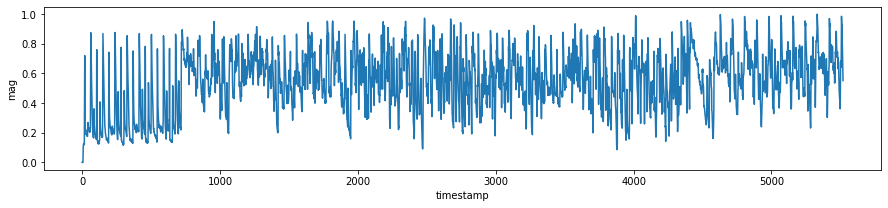

In [23]:
plt.figure(figsize=(15, 3))
plt.xlabel('timestamp')
plt.ylabel('mag')
plt.plot(mag_simp[int(mag_frame_rate) * 0:int(mag_frame_rate) * 120])
plt.show()

In [20]:
# save mag
meta_simp = {
    "shape": list(mag_simp.shape),
    "time": total_sec,
    "rate": mag_frame_rate,
    "data": mag_simp.tolist()
}

with open('meta_simp.json', 'w') as fp:
    json.dump(meta_simp, fp)